In [1]:
### imports

In [2]:
import tensorflow as tf

# keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add, GlobalAveragePooling2D 
from keras.layers import GaussianNoise, DepthwiseConv2D, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger 
from keras.regularizers import l1_l2

# Image Preprocessing
import cv2
import numpy as np

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt

# other
from glob import glob
import time
import pickle

/home/apps/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/apps/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/apps/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/apps/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
# prevent keras from using the whole GPU
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
# Set global variables
# data dir
TRAIN_DIR = '/YOUR_PATH/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '/YOUR_PATH/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

# params of the data
CLASSES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CLASSES.sort()
N_CLASSES = len(CLASSES)
INPUT_DIMS = (64,64,3) # 64*64 RGB images
TARGET_SIZE = (64, 64)

# approximate data mean and variance, computed on subset of training data
(R_MEAN, G_MEAN, B_MEAN) = (132.54925778832765,127.47777489388343,131.40493902829613)
(R_VAR, G_VAR, B_VAR) = (57.8223931610762,64.89711912659384,66.70657380138726)

# experiment params
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 32
# where to save the model
MODEL_DIR = '/YOUR_PATH/asl-alphabet/models'

In [5]:
# regulizer used by model
l1l2_reg = l1_l2(l1=0.0001, l2=0.0001)

In [6]:
### Define the model
# slim-cnn
inputs = Input(shape=INPUT_DIMS)

# add noise to inputs
net = GaussianNoise(0.001)(inputs)

net = Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_regularizer=l1l2_reg, )(net)
net = LeakyReLU()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = Add()([net, shortcut])

net = GlobalAveragePooling2D()(net)
net = Dropout(0.2)(net)

net = Dense(128, activation='relu', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)
outputs = Dense(N_CLASSES, activation='softmax', kernel_regularizer=l1l2_reg, kernel_initializer='he_normal')(net)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
def preprocess_image(image):
    '''Function that will be implied on each input. The function
    will run after the image is resized and augmented.
    The function should take one argument: one image (Numpy tensor
    with rank 3), and should output a Numpy tensor with the same
    shape.'''

    # apply sobelY change
#     img = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    # apply sobelXY change
#     img = cv2.Sobel(image, cv2.CV_64F, 1 1, ksize=5)    
    # apply laplacian (+blur)
    image = cv2.GaussianBlur(image, (7, 7), 0)
    image = cv2.Laplacian(image, cv2.CV_64F, ksize=5)
   
    return image

In [8]:
# define the data generators
augmentor_options = {
    'samplewise_center': True,
    'samplewise_std_normalization': True,
    'horizontal_flip':True,
    'validation_split':VALIDATION_SPLIT,
    'preprocessing_function': preprocess_image,
    'rotation_range':30,
    'width_shift_range':0.2,
    'height_shift_range':0.2,
    'brightness_range':(0.66,1.33),
    'zoom_range':[0.666,1.333],
    'shear_range':0.2,
    'channel_shift_range':63,
}

data_augmentor = ImageDataGenerator(**augmentor_options)

flow_options = {
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'shuffle': True,
}

training_generator = data_augmentor.flow_from_directory(TRAIN_DIR, subset='training', **flow_options)
validation_generator = data_augmentor.flow_from_directory(TRAIN_DIR, subset='validation', **flow_options)

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [9]:
start_time = time.time()

# save model architecture
model.save(MODEL_DIR + '/slim-cnn-model_{}.archi.h5'.format(start_time))

# call backs for model checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_DIR+'/slim-cnn-model_{}.weights.h5'.format(start_time),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# callback for logging history
csv_logger = CSVLogger(MODEL_DIR+'/slim-cnn-model_{}.history.csv'.format(start_time))

history = None
history = model.fit_generator(training_generator,
                              epochs=5,
                              validation_data=validation_generator,
                              callbacks=[model_checkpoint_callback, csv_logger],
                              verbose=1)

print('Fitting the model took ~{:.0f} second(s).'.format(time.time() - start_time))


Epoch 1/5
2447/2447 [==============================] - 384s 157ms/step - loss: 2.6190 - accuracy: 0.3105 - val_loss: 2.4582 - val_accuracy: 0.4551
Epoch 2/5
2447/2447 [==============================] - 379s 155ms/step - loss: 1.8317 - accuracy: 0.5261 - val_loss: 1.4206 - val_accuracy: 0.6018
Epoch 3/5
2447/2447 [==============================] - 379s 155ms/step - loss: 1.5939 - accuracy: 0.6042 - val_loss: 1.7665 - val_accuracy: 0.5806
Epoch 4/5
2447/2447 [==============================] - 381s 156ms/step - loss: 1.4632 - accuracy: 0.6460 - val_loss: 2.2083 - val_accuracy: 0.5469
Epoch 5/5
2447/2447 [==============================] - 381s 156ms/step - loss: 1.3804 - accuracy: 0.6758 - val_loss: 1.6797 - val_accuracy: 0.5715
Fitting the model took ~1907 second(s).


In [10]:
# save slim-cnn model final weights (not necessarily the best because of overfitting)
model.save_weights(MODEL_DIR + '/slim-cnn-model_{}.weights.final.h5'.format(start_time))

In [11]:
print('Final Accuracy: {:.2f}%'.format(history.history['accuracy'][-1] * 100))
print('Validation set accuracy: {:.2f}%'.format(history.history['val_accuracy'][-1] * 100))

Final Accuracy: 67.58%
Validation set accuracy: 57.15%


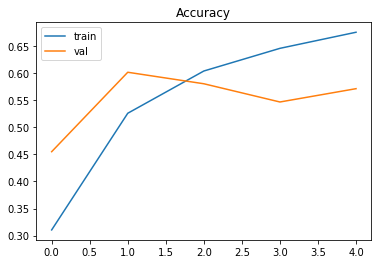

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()